## Summary

Created: 10/20/2017 (cloned from part2_analysis_wasp21)

Last edit: 10/24

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

In [4]:
#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [5]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*band.csv')
file_list.sort()
len(file_list)

3

## import lc

In [6]:
data_dir='.'

name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='13'#3
radii_range='9-14'

data={}
bands='g,r,z'.split(',')
sigma=5

for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    #manipulate columns
    cols = df.columns.tolist()
    cols.remove('#')
    cols.insert(-1,' ')
    df.columns = cols
    try:
        df=df.drop(['Unnamed: 21','frame', ' '],axis=1)
    except:
        pass
    df=df.set_index('BJD(TDB)-2450000')
    #df['BJD(TDB)'] = df['BJD(TDB)-2450000'].apply(lambda x: x + 2450000)
    #df=df.set_index('BJD(TDB)')
    #remove outliers
    data[b]=df[np.abs(df-df.mean())<=(sigma*df.std())]

In [7]:
data[b].head()

,airmass,sky(ADU),dx(pix),dy(pix),fwhm(pix),peak(ADU),flux(r=9.0),err(r=9.0),flux(r=10.0),err(r=10.0),flux(r=11.0),err(r=11.0),flux(r=12.0),err(r=12.0),flux(r=13.0),err(r=13.0),flux(r=14.0),err(r=14.0)
BJD(TDB)-2450000,,,,,,,,,,,,,,,,,,
7800.099704,1.9195,769.0,1.571,1.098,9.52,8484.4,1.008784,0.002271,1.005945,0.002288,1.004211,0.002324,1.003111,0.002372,1.002090,0.002429,1.002103,0.002496
7800.100445,1.9101,759.6,1.183,1.363,9.05,8832.8,1.006547,0.002261,1.005888,0.002283,1.005840,0.002323,1.005248,0.002372,1.005178,0.002431,1.003958,0.002494
7800.101185,1.9007,758.7,2.001,0.490,8.82,9166.4,1.014396,0.002273,1.012732,0.002296,1.011233,0.002333,1.010332,0.002383,1.009567,0.002441,1.008458,0.002506
7800.101926,1.8915,757.1,2.197,1.278,8.82,9004.7,1.001108,0.002271,1.000193,0.002290,0.999210,0.002325,0.998171,0.002371,0.998673,0.002430,0.999014,0.002494
7800.102655,1.8826,753.3,1.232,1.128,8.28,9894.7,1.010541,0.002235,1.009920,0.002263,1.009409,0.002305,1.009090,0.002359,1.007839,0.002417,1.007942,0.002484


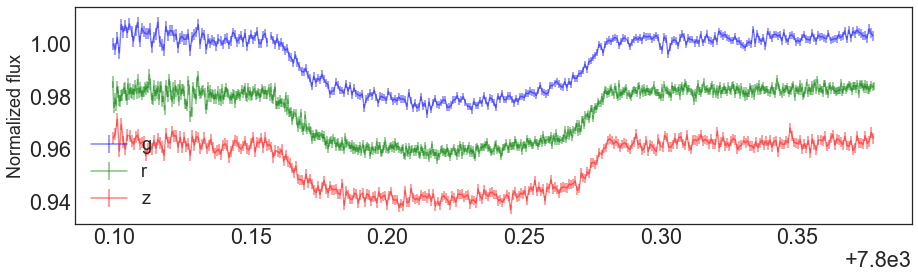

In [8]:
fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux')
    n+=1
pl.legend(loc='lower left')

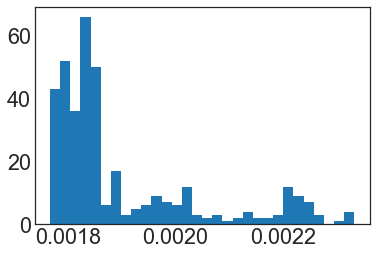

In [44]:
pl.hist(err,bins=30);

In [45]:
np.percentile(err, [0.05,0.95])

array([ 0.00176719,  0.001771  ])

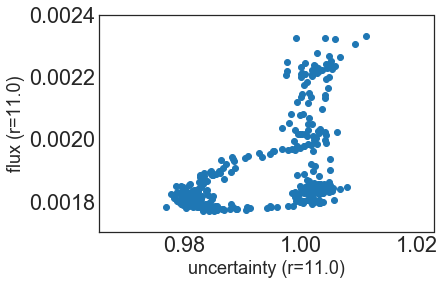

In [53]:
pl.scatter(flux,err)
pl.ylim(0.0017,0.0024)
pl.xlabel('uncertainty (r=11.0)')
pl.ylabel('flux (r=11.0)')

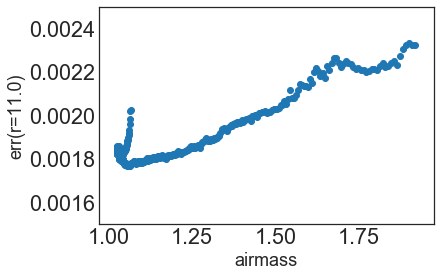

In [67]:
pl.scatter(airmass,err)
pl.ylim(0.0015,0.0025)
pl.xlabel('airmass')
pl.ylabel('err(r=11.0)')

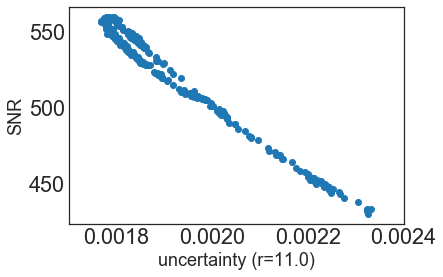

In [57]:
pl.scatter(err,flux/err)
pl.xlim(0.0017,0.0024)
pl.xlabel('uncertainty (r=11.0)')
pl.ylabel('SNR')

## building the model

* See [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b) for published transit parameters

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [9]:
tc_0  = 7.8e3+0.22
_P   = 4.301219
_t14 = 0.1302
_b   = 0.172
_a_s = 11.52
_k   = np.sqrt(0.01804)
_inc = np.deg2rad(89.10)

In [10]:
from pytransit import MandelAgol
MA = MandelAgol()

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def model_q(theta, t, p):
    '''
    p is an argument because it is well known from previous observation
    '''
    
    k,tc,a,ip,q1,q2 = theta[:6]
    inc   = np.arccos(ip/a)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, inc)
    return model

## Limb-darkening prior
* Limb-darkening coefficients inference from stellar parameters [Claret (2012)](https://www.aanda.org/articles/aa/pdf/2012/10/aa19849-12.pdf)

```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [11]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1
u1,u1err, u2,u2err = lb.claret('g*', teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
u1,u1err, u2,u2err

(0.74890000000000001,
 0.03693473122240231,
 0.072999999999999995,
 0.030100222629847774)

In [12]:
q1_, q2_       = u_to_q(u1, u2)
q1err_, q2err_ = u_to_q(u1err, u2err)

theta_true= [_k,tc_0,_a_s, _b, q1_, q2_]

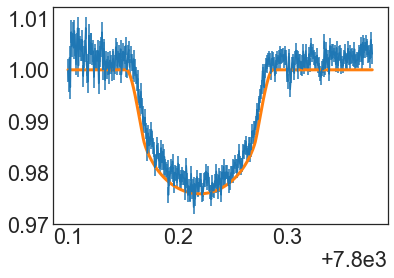

In [13]:
b='g'
f=data[b][fluxcol]
t=data[b].index

m=model_q(theta_true, t, _P)

pl.errorbar(data[b].index,f,yerr=data[b][errcol])
pl.plot(t,m,lw=3)

In [14]:
import limbdark as lb

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

#limbdark priors
ldp = []
for i in 'g*,r*,z*'.split(','):
    ldp.append(lb.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4)))

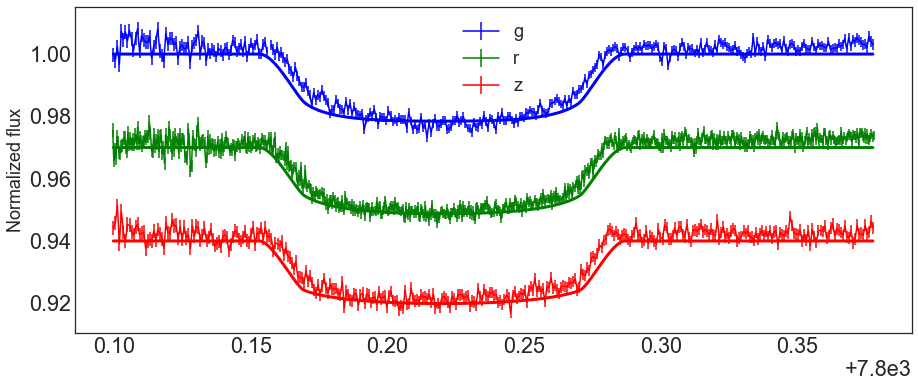

In [15]:
colors='b,g,r'.split(',')

fig,ax = pl.subplots(1,1,figsize=(15,6))

theta_vec = []

i = 0
for b,c in zip(bands,colors):
    df = data[b]
    
    offset = 0.03*i
    
    #plot data
    time = data[b].index
    flux = data[b][fluxcol]
    err  = data[b][errcol]
    
    ax.errorbar(time,flux-offset,yerr=err,color=c,label=b)
    
    #suppose k changes (gets slightly smaller from g to z band)
    k_0    = _k-0.001*i
    q1_,q2_ = ldp[i][0], ldp[i][2]
    
    #compute model
    theta = [k_0,tc_0,_a_s, _b, q1_, q2_]
    m=model_q(theta, t, _P)
    
    
    #plot model
    ax.plot(t,m-offset,color=c,lw=3)
    ax.set_ylabel('Normalized flux')
    theta_vec.append(theta)
    
    #increase counter
    i = i+1
    
pl.legend()

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [16]:
import scipy.optimize as op

def obj(theta, t, f, p, err):
    '''
    objective function: chi-squared
    '''
    m = model_q(theta, t, p)
    return np.sum((m-f)**2/err**2)

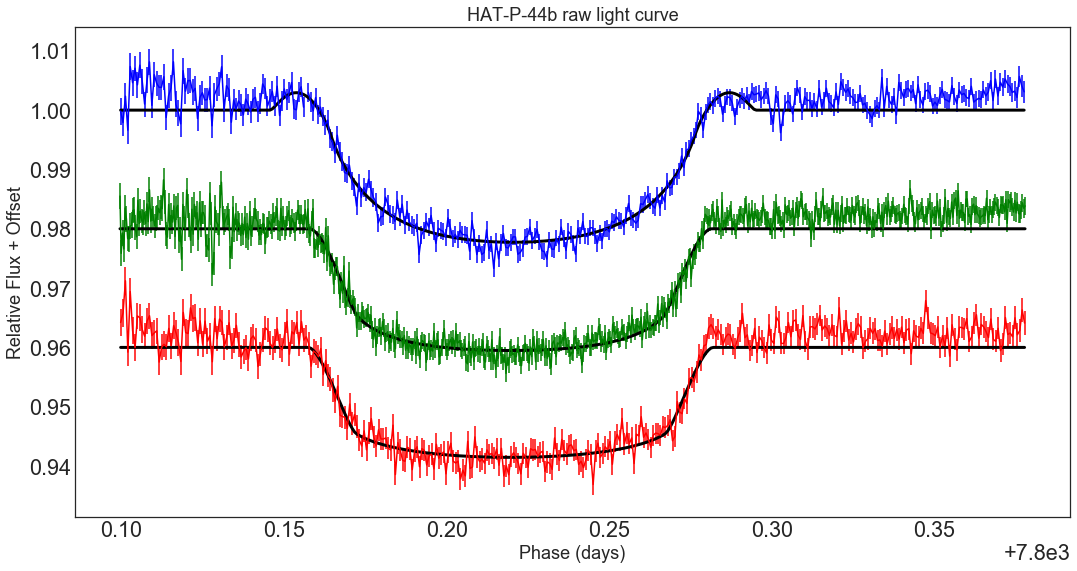

In [17]:
fontsize=18

ts,fluxes=[],[]
airmasses,errors,dxs,dys=[],[],[],[]

bands = sorted('g,r,z'.split(','))
colors='b,g,r'.split(',')

fig, axs = pl.subplots(1,1, figsize=(15,8), sharey=True)
for n,(b,c) in enumerate(zip(bands,colors)):
    df=data[b]    
    f=df[fluxcol]
    t=f.index
    err = df[errcol]
    
    ts.append(t)
    fluxes.append(f)
    
    #plot data
    #axs.plot(t,f-0.02*i, drawstyle='steps-mid', c=colors[i])
    axs.errorbar(t,f-0.02*n, yerr=err, color=c)
    res = op.minimize(obj, theta_vec[n], args=(t, f, _P, err), method='nelder-mead')
    model = model_q(res.x, t, _P)
    
    axs.plot(t, model-0.02*n, 'k-', lw=3);
    
    fig.tight_layout()

    
    #sys mod params
    airmasses.append(df['airmass'].values)
    errors.append(df['err(r=11.0)'].values)
    #peak_fluxes.append(d['peak'].values)
    #fwhms.append(d['fwhm'].values)
    dxs.append(df['dx(pix)'].values)
    dys.append(df['dy(pix)'].values)
    
axs.set_title('HAT-P-44b raw light curve',fontsize=fontsize)
axs.set_ylabel('Relative Flux + Offset',fontsize=fontsize)
axs.set_xlabel('Phase (days)',fontsize=fontsize)

In [18]:
#systematics model (time-dependent)
def model_s(theta, aux_vec, t):
    airmass, xcenter, ycenter = aux_vec
    #functional form of systematics model
    offset = np.ones(len(t))
    s = (np.array(theta)*np.c_[airmass, xcenter, ycenter, offset, t]).sum(axis=1)
    #s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    # unpack 6 free params
    #a,b,c,d,e = theta
    #s = a + b*t + c*fwhm + d*xcenter + e*ycenter
    return s

def loglike(theta, t, f, p, err, aux_vec, 
            ret_mod=False, ret_sys=False, ret_full = False):
    #airmass, xcenter, ycenter = aux_vec
    #ls = theta[6]
    m = model_q(theta[:6], t, p)
    s = model_s(theta[6:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m+s
    
    resid = f - m - s
    
    C = np.log(2*np.pi)/2
    
    #-0.5*(np.sum((resid)**2 * np.exp(-2*ls) + 2*ls))
    
    return -np.sum(np.log(err) + C + (resid**2/2*err**2))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -2085.9190312309383
NLL after: -2085.919031231978
residual: std=0.0021, rms=0.0027
--r--
NLL before: -3925.098235491726
NLL after: -3925.0982354932435
residual: std=0.0019, rms=0.0025
--z--
NLL before: -2011.5957585267702
NLL after: -2011.595758528203
residual: std=0.0020, rms=0.0028


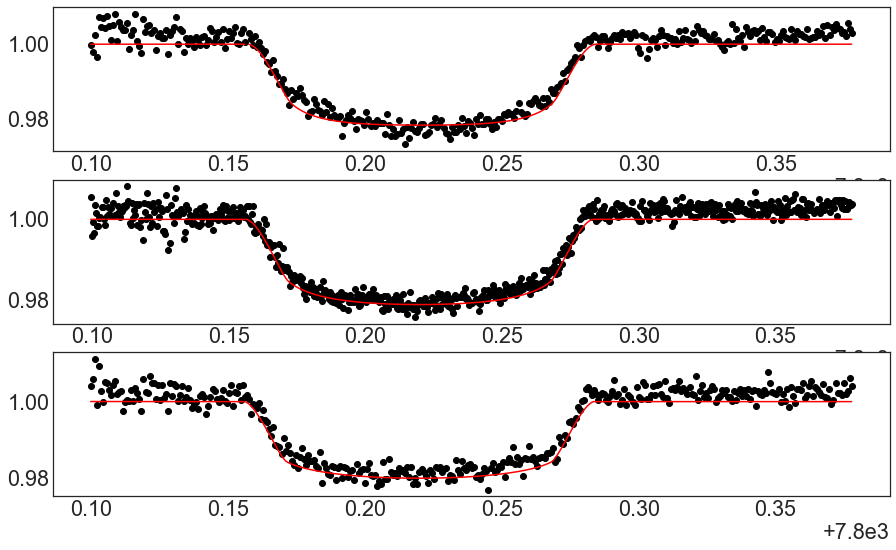

In [20]:
#systematics parameters
k0, k1, k2, k3, k4, k5, k6, k7, k8, k9 = [0]*10
#log flux uncertainty
k_list= [k0, k1, k2, k3, k4, k5, k6, k7, k8, k9]
nparams=5

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

for n,b in enumerate(sorted(bands)):
    d=data[b]
    

    f=d[fluxcol]
    t=f.index

    #sys mod params
    airmass   = d['airmass'].values
    err       = d['err(r=11.0)'].values
    #peak_flux=d['peak(ADU)'].values
    #fwhm = d['fwhm(pix)'].values
    dx        = d['dx(pix)'].values
    dy        = d['dy(pix)'].values
    fwhm      = d['fwhm(pix)'].values
    sky       = d['sky(ADU)'].values
    peak      = d['peak(ADU)'].values
    print('--{}--'.format(b))
        
    k_0    = _k-0.001*n
    q1_,q2_ = ldp[n][0], ldp[n][2]
    
    theta = [k_0,tc_0,_a_s, _b, q1_, q2_]
    theta_full = np.concatenate((theta, k_list[:nparams]))
    
    aux_vec = (airmass, dx, dy)
    print ("NLL before: {}".format(nll(theta_full, t, f, _P, err, aux_vec)))
    
    result = op.minimize(nll, theta_full,    args=(t, f, _P, err, aux_vec), 
                         method='nelder-mead')
    print ("NLL after: {}".format(nll(result.x,    t, f, _P, err, aux_vec)))

    f_pred = loglike(result.x, t, f, _P, err, aux_vec, ret_full=True)
    mod    = loglike(result.x, t, f, _P, err, aux_vec, ret_mod=True)
    sys    = loglike(result.x, t, f, _P, err, aux_vec, ret_sys=True)
    
    resid=f-f_pred #f-mod-sys
    sigma=np.std(resid)
    rms=np.sqrt(np.mean(resid**2))
    print('residual: std={0:.4f}, rms={1:.4f}'.format(sigma, rms))
    
    ax = pl.subplot(3,1,n+1)
    ax.plot(t, f, 'ko', t, f_pred, 'r-');

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

In [21]:
theta

[0.13231306712304652, 7800.22, 11.52, 0.172, 0.2387, 0.32579999999999998]

In [22]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    a/Rs: scaled semi-major axis
    
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

_t14  = 0.13020
_b    = 0.172
a_s_  = scaled_a(_P, _t14, _k, i=_inc, impact_param=_b)
a_s_

11.809211418629959

In [23]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [24]:
k

0.13431306712304653+/-0.016431676725154984

In [25]:
#uncertainty in k
Rp/Rs

0.16491840817134548+/-0.04984031996673391

In [26]:
from uncertainties.umath import *

num   = ((k + 1)**2 - b**2)**(0.5)
denom = sin(inc) * sin(t14 * np.pi / P)

#uncertainty in a_s
a_s = num/denom
a_s

11.809211418629959+/-0.22844457501225646

In [27]:
_a_s

11.52

In [28]:
a_s.n-a_s.s, a_s.n+a_s.s 

(11.580766843617702, 12.037655993642215)

In [29]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [30]:
tshape = tshape_approx(_a_s, _k, _b)
kmax = max_k(tshape)
kmax

0.1384877403319339

## Prior

In [31]:
from scipy import stats
def logprior(theta,up=None):
    '''
    up: u prior
    '''
    k,tc,a,impact_param,q1,q2 = theta[:6]
    inc=np.arccos(impact_param/a)
    
    #or k from 0 up to order of max_k (Seager paper)?
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0.1 or k  > kmax or \
        impact_param < 0 or impact_param  > 0.99 or \
        tc  < tc_0-_t14/2 or tc > tc_0+_t14/2:
            
        #print('off limits encountered in logprior')
        return -np.inf

    lp = 0
    #u prior
    u1,u2 = q_to_u(q1,q2)
    
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))
    #
    
    return lp

def logprob(theta_sys,ts,fluxes,p,errors,airmasses,dxs,dys,up=None):
    t1,t2,t3 = ts
    f1,f2,f3 = fluxes
    err1,err2,err3 = errors
    airmass1,airmass2,airmass3 = airmasses
    xcen1,xcen2,xcen3 = dxs
    ycen1,ycen2,ycen3 = dys
    k1,k2,k3,tc,a_s,impact_param,q1g,q2g,q1r,q2r,q1z,q2z,\
    k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43 = theta_sys
    
    theta1 = [k1,tc,a_s,impact_param,q11,q21,k01,k11,k21,k31,k41]
    theta2 = [k2,tc,a_s,impact_param,q12,q22,k02,k12,k22,k32,k42]
    theta3 = [k3,tc,a_s,impact_param,q13,q23,k03,k13,k23,k33,k43]
    
    aux_vec1 = airmass1, xcen1, ycen1
    aux_vec2 = airmass2, xcen2, ycen2
    aux_vec3 = airmass3, xcen3, ycen3
    
    #sum loglike for each band
    ll  = loglike(theta1, t1, f1, p, err1, aux_vec1)
    ll += loglike(theta2, t2, f2, p, err2, aux_vec2)
    ll += loglike(theta3, t3, f3, p, err3, aux_vec3)
    
    if up is not None:
        lp  = logprior(theta1,up=up[0])
        lp += logprior(theta2,up=up[1])
        lp += logprior(theta3,up=up[2])
    else:
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

sanity check

In [32]:
theta_vec=[]
for i,j in enumerate(bands):
    #a.append(scaled_a(p_, t14_, k_, inc=np.pi/2))
    k_0    = _k+0.001*i
    q1_,q2_ = ldp[i][0], ldp[i][2]
    theta = [k_0,tc_0,_a_s, _b, q1_, q2_]
    theta.append(theta_vec)

k1,k2,k3     = [_k-0.001,_k-0.002,_k-0.002]
#q1: g, r, z
q1g,q1r, q1z = ldp[0][0], ldp[1][0], ldp[2][0]
#q2: g, r, z
q2g,q2r, q2z = ldp[0][2], ldp[1][2], ldp[2][2]

#systematics parameters
k01, k11, k21, k31, k41 = [0] * 5
k02, k12, k22, k32, k42 = [0] * 5
k03, k13, k23, k33, k43 = [0] * 5


#log flux uncertainty
#ls1,ls2,ls3 = [np.log(np.nanstd(f)) for f in fluxes]  
t1,t2,t3         = ts
f1,f2,f3         = fluxes
xcen1,xcen2,xcen3= dxs
ycen1,ycen2,ycen3= dys
airmass1,airmass2,airmass3=airmasses
#fwhm1,fwhm2,fwhm3= fwhms
#unc1,unc2,unc3   = uncs

In [33]:
theta_full = [k1,k2,k3,tc_0,_a_s,_b,q1g,q2g,q1r,q2r,q1z,q2z,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43]
args = [ts,fluxes,_P,errors,airmasses,dxs,dys]

In [34]:
#without ldp
logprob(theta_full, *args)

8022.613025246741

In [35]:
#with ldp
logprob(theta_full, *args, up=ldp)

7558.1386230775624

In [36]:
#with ldp
args = [ts,fluxes,_P,errors,airmasses,dxs,dys,ldp]

In [37]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

ndim = len(theta_full)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 100

sampler = EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

#random initial condition
pos0 = sample_ball(theta_full, [1e-4]*ndim, nwalkers)
'''pos0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
      for i in xrange(nwalkers)]'''

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

89it [03:03,  1.65s/it]/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
100it [03:24,  1.67s/it]


In [40]:
nsteps2 = 500

sampler.reset()

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

4it [00:07,  1.95s/it]/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
500it [15:24,  2.00s/it]


## Initial results: Parameter best estimates (including burn-in)

In [41]:
chain = sampler.chain
chain.shape

(216, 500, 27)

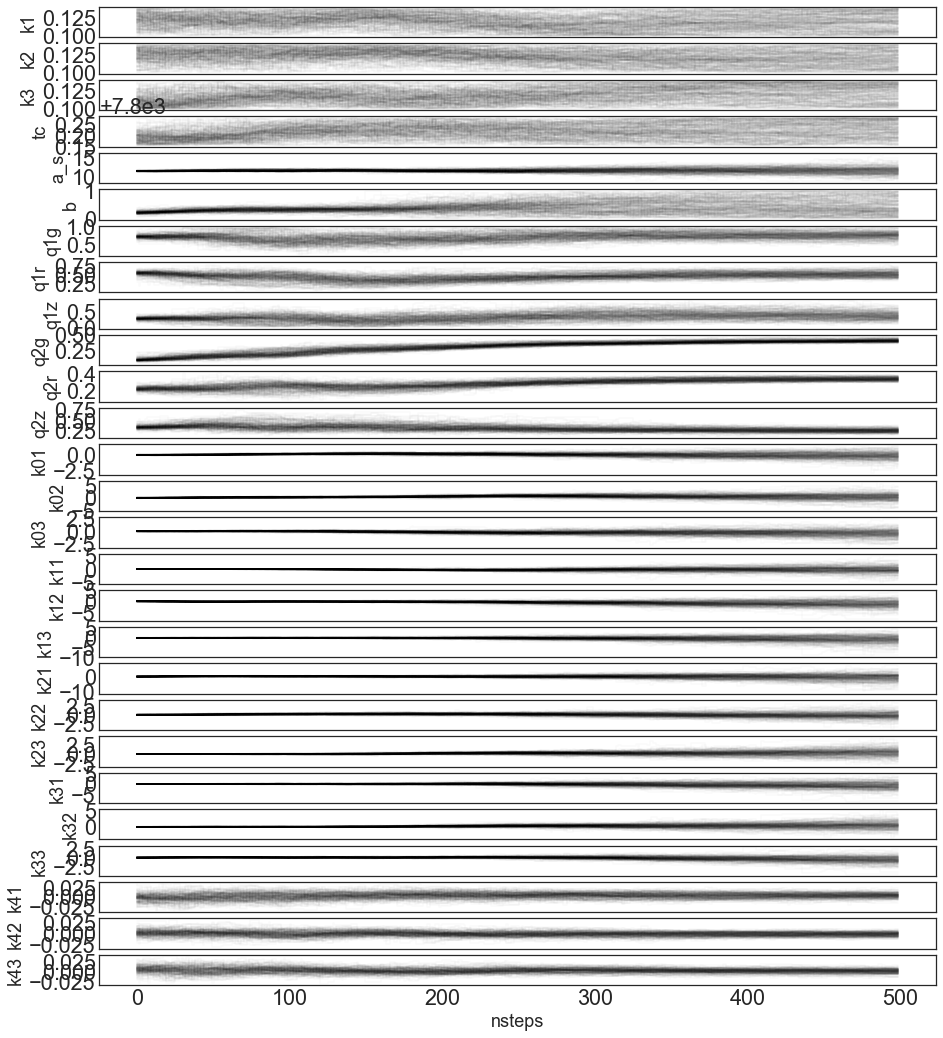

In [42]:
pl.style.use('seaborn-white')

param_names='k1,k2,k3,tc,a_s,b,q1g,q1r,q1z,q2g,q2r,q2z,k01,k02,k03,k11,k12,k13,k21,k22,k23,k31,k32,k33,k41,k42,k43'.split(',')
    
nwalkers, nsteps, ndim = chain.shape
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
#ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
#percs = [np.percentile(sampler.chain2[:,:,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
#[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')